Goal: Create Dataset with data from every pixel over time

In [105]:
import os
import glob
import rasterio
import numpy as np
import pandas as pd
from rasterio.enums import Resampling
from rasterio.warp import reproject
import re

###############################################################################
# 1. Use the revised detect_dataset_type and extract_year
###############################################################################

def detect_dataset_type(file_path):
    name = os.path.basename(file_path)
    name_lower = name.lower()

    if "population_" in name_lower:
        return "pop"
    elif "ndvi_" in name_lower:
        return "ndvi"
    elif "lst_" in name_lower:
        return "lst"
    elif "_gp" in name_lower:
        return "gpp"
    elif "lct" in name_lower:
        return "landcover"
    elif re.search(r'(20\d{2})r\.tif$', name_lower):
        return "precip"
    else:
        return None

def extract_year(file_path):
    import re
    name = os.path.basename(file_path)
    match = re.search(r'(20\d{2})', name)
    if match:
        return int(match.group(1))
    return None

###############################################################################
# 2. Search folders for TIFs
###############################################################################
base_folder = "Datasets_Hackathon 1/Datasets_Hackathon"  # Adjust if needed
all_tifs = glob.glob(os.path.join(base_folder, "**/*.tif"), recursive=True)

files_dict = {
    "landcover": {},
    "ndvi": {},
    "lst": {},
    "pop": {},
    "gpp": {},
    "precip": {}
}

for fp in all_tifs:
    dset_type = detect_dataset_type(fp)
    if not dset_type:
        continue
    year = extract_year(fp)
    if not year:
        continue
    files_dict[dset_type][year] = fp

# For years 2021-2023, copy population from 2020 if missing
for y in [2021, 2022, 2023]:
    if y not in files_dict["pop"] and 2020 in files_dict["pop"]:
        files_dict["pop"][y] = files_dict["pop"][2020]

###############################################################################
# 3. Pick a Land Cover raster to define resolution/extent
###############################################################################
# We'll try 2010, or any other year available.
if 2010 in files_dict["landcover"]:
    ref_path = files_dict["landcover"][2010]
else:
    lc_years = sorted(files_dict["landcover"].keys())
    if lc_years:
        ref_path = files_dict["landcover"][lc_years[0]]
    else:
        raise RuntimeError("No land cover files found!")

with rasterio.open(ref_path) as src_ref:
    ref_data = src_ref.read(1)
    ref_profile = src_ref.profile
    ref_transform = src_ref.transform
    ref_crs = src_ref.crs
    ref_height, ref_width = ref_data.shape

###############################################################################
# 4. Helper to resample
###############################################################################
def resample_to_reference(source_path, cap_gpp=False):
    with rasterio.open(source_path) as src:
        arr_src = src.read(1)
        transform_src = src.transform
        crs_src = src.crs
        
        dest_data = np.zeros((ref_height, ref_width), dtype=np.float32)

        reproject(
            arr_src,
            dest_data,
            src_transform=transform_src,
            src_crs=crs_src,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=Resampling.bilinear
        )

        # Cap GPP if needed
        if cap_gpp:
            dest_data[dest_data > 4000] = 0
        
        return dest_data

###############################################################################
# 5. Load and resample all data for 2010-2023
###############################################################################
import scipy.ndimage
years = range(2010, 2024)
data_by_type = {k: {} for k in files_dict.keys()}

for y in years:
    # landcover
    if y in files_dict["landcover"]:
        data_by_type["landcover"][y] = resample_to_reference(files_dict["landcover"][y])
    else:
        data_by_type["landcover"][y] = None
    
    # ndvi
    if y in files_dict["ndvi"]:
        data_by_type["ndvi"][y] = resample_to_reference(files_dict["ndvi"][y])
    else:
        data_by_type["ndvi"][y] = None

    # lst
    if y in files_dict["lst"]:
        data_by_type["lst"][y] = resample_to_reference(files_dict["lst"][y])
    else:
        data_by_type["lst"][y] = None

    # pop
    if y in files_dict["pop"]:
        data_by_type["pop"][y] = resample_to_reference(files_dict["pop"][y])
    else:
        data_by_type["pop"][y] = None

    # gpp
    if y in files_dict["gpp"]:
        data_by_type["gpp"][y] = resample_to_reference(files_dict["gpp"][y], cap_gpp=True)
    else:
        data_by_type["gpp"][y] = None

    # precip
    if y in files_dict["precip"]:
        with rasterio.open(files_dict["precip"][y]) as src:
            precip_arr = src.read(1)  # Read precipitation raster
            
            # Handle missing values (replace 65533 with NaN)
            precip_arr = precip_arr.astype(np.float32)  # Ensure float type for NaN handling
            precip_arr[precip_arr == 65533] = np.nan

            # Ensure it matches the reference resolution
            dest_data = np.zeros((ref_height, ref_width), dtype=np.float32)

            reproject(
                source=precip_arr,
                destination=dest_data,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref_transform,
                dst_crs=ref_crs,
                resampling=Resampling.nearest  # Assign nearest precipitation values to pixels
            )

            # Fill NaN values with nearest non-NaN neighbor
            nan_mask = np.isnan(dest_data) | (dest_data == -3.402823e+38)
            if np.any(nan_mask):  # Only run if there are NaNs
                filled_data = dest_data.copy()
                filled_data[nan_mask] = scipy.ndimage.distance_transform_edt(nan_mask) * 0
                filled_data = scipy.ndimage.distance_transform_edt(nan_mask, return_distances=False, return_indices=True)
                filled_data = dest_data[tuple(filled_data)]
                dest_data = filled_data  # Replace NaN-filled data

            data_by_type["precip"][y] = dest_data
    else:
        data_by_type["precip"][y] = None

###############################################################################
# 6. Assemble into a DataFrame
###############################################################################
rows = []
for y in years:
    lc_arr   = data_by_type["landcover"][y]
    if lc_arr is None:
        # skip if no landcover for this year
        continue
    
    # flatten landcover
    lc_flat = lc_arr.flatten()
    
    # flatten other variables or fill with NaN
    ndvi_arr = data_by_type["ndvi"][y]
    ndvi_flat = ndvi_arr.flatten() if ndvi_arr is not None else np.full(lc_flat.shape, np.nan)
    
    lst_arr = data_by_type["lst"][y]
    lst_flat = lst_arr.flatten() if lst_arr is not None else np.full(lc_flat.shape, np.nan)

    pop_arr = data_by_type["pop"][y]
    pop_flat = pop_arr.flatten() if pop_arr is not None else np.full(lc_flat.shape, np.nan)

    gpp_arr = data_by_type["gpp"][y]
    gpp_flat = gpp_arr.flatten() if gpp_arr is not None else np.full(lc_flat.shape, np.nan)

    prc_arr = data_by_type["precip"][y]
    prc_flat = prc_arr.flatten() if prc_arr is not None else np.full(lc_flat.shape, np.nan)

    # Make a DataFrame for this year
    temp_df = pd.DataFrame({
        f"LC_{y}": lc_flat,
        f"NDVI_{y}": ndvi_flat,
        f"LST_{y}": lst_flat,
        f"POP_{y}": pop_flat,
        f"GPP_{y}": gpp_flat,
        f"PRECIP_{y}": prc_flat,
        "pixel_id": np.arange(len(lc_flat))
    })
    rows.append(temp_df)

# Merge across all years on pixel_id => wide table
df_full = None
for year_df in rows:
    if df_full is None:
        df_full = year_df
    else:
        df_full = df_full.merge(year_df, on="pixel_id", how="outer")

###############################################################################
# 7. Exclude invalid land cover classes -128 and 255
###############################################################################
lc_cols = [c for c in df_full.columns if c.startswith("LC_")]
mask_invalid = np.zeros(len(df_full), dtype=bool)
for c in lc_cols:
    mask_invalid |= (df_full[c] == -128) | (df_full[c] == 255)

df_filtered = df_full[~mask_invalid].copy()

for y in years:
    df_filtered[f"NDVI_{y}"]= 0.0001 *  df_filtered[f"NDVI_{y}"]

print("Final DataFrame shape:", df_filtered.shape)
print(df_filtered.head())

# Save to CSV if desired
df_filtered.head().to_csv("final_pixel_dataframe.csv", index=False)
print("DataFrame saved to final_pixel_dataframe.csv")


Final DataFrame shape: (168212, 85)
      LC_2010  NDVI_2010   LST_2010  POP_2010  GPP_2010   PRECIP_2010  \
475      16.0   0.100435  40.922581  0.006259       0.0 -3.402823e+38   
1039     16.0   0.108242  41.056068  0.005568       0.0 -3.402823e+38   
1040     16.0   0.100624  40.807373  0.005553       0.0 -3.402823e+38   
1603     16.0   0.109151  40.763355  0.005525       0.0 -3.402823e+38   
1604     16.0   0.101587  40.485077  0.005415       0.0 -3.402823e+38   

      pixel_id  LC_2011  NDVI_2011   LST_2011  ...   LST_2022  POP_2022  \
475        475     16.0   0.103633  41.960651  ...  39.550652  0.007126   
1039      1039     16.0   0.107574  42.358791  ...  39.756775  0.005950   
1040      1040     16.0   0.100824  41.900337  ...  39.534119  0.005174   
1603      1603     16.0   0.106553  42.219372  ...  39.943565  0.005401   
1604      1604     16.0   0.099491  41.864021  ...  39.667461  0.004754   

      GPP_2022   PRECIP_2022  LC_2023  NDVI_2023   LST_2023  POP_2023  \
4

In [129]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Load the district boundaries
assaba_districts = gpd.read_file("Datasets_Hackathon 1/Datasets_Hackathon/Admin_layers/Assaba_Districts_layer.shp")

# Convert to the same CRS as your dataset (Assuming WGS84 EPSG:4326)
assaba_districts = assaba_districts.to_crs(epsg=4326)

# Check the first rows
print(assaba_districts.head())


   FID_1    ADM3_EN ADM3_PCODE ADM3_REF    ADM2_EN ADM2_PCODE ADM1_EN  \
0     71  El Ghabra    MR03106     None    Barkéol      MR031  Assaba   
1     77     Guerou    MR03301     None     Guerou      MR033  Assaba   
2     66  Barkeiwel    MR03101     None    Barkéol      MR031  Assaba   
3     91    Legrane    MR03506     None      Kiffa      MR035  Assaba   
4     82       Sani    MR03402     None  Kankoussa      MR034  Assaba   

  ADM1_PCODE     ADM0_EN ADM0_PCODE       date    validOn     validTo  \
0       MR03  Mauritania         MR 2024-03-06 2024-03-27  0000/00/00   
1       MR03  Mauritania         MR 2024-03-06 2024-03-27  0000/00/00   
2       MR03  Mauritania         MR 2024-03-06 2024-03-27  0000/00/00   
3       MR03  Mauritania         MR 2024-03-06 2024-03-27  0000/00/00   
4       MR03  Mauritania         MR 2024-03-06 2024-03-27  0000/00/00   

   Shape_Leng  Shape_Area    AREA_SQKM  \
0    1.064756    0.047306   558.684431   
1    0.466595    0.009926   117.075519

In [124]:
reference_tif = "Datasets_Hackathon 1/Datasets_Hackathon/Modis_Land_Cover_Data/2010LCT.tif"

with rasterio.open(reference_tif) as src:
    transform = src.transform  # affine transform (maps col/row to x/y)
    width = src.width          # number of columns
    height = src.height        # number of rows
    crs = src.crs              # coordinate reference system (just for your info)

print("Raster width:", width, "height:", height)
print("Transform:", transform)
print("CRS:", crs)

import numpy as np

df_filtered["row"] = df_filtered["pixel_id"] // width
df_filtered["col"] = df_filtered["pixel_id"] % width

print(df_filtered[["pixel_id", "row", "col"]].head())

xcoords = []
ycoords = []

for i, row_data in df_filtered.iterrows():
    r = row_data["row"]
    c = row_data["col"]
    # Transform to x,y
    x, y = transform * (c, r)  # note the order: (col, row)
    xcoords.append(x)
    ycoords.append(y)

df_filtered["xcoord"] = xcoords
df_filtered["ycoord"] = ycoords

print(df_filtered[["pixel_id", "row", "col", "xcoord", "ycoord"]].head())

df = df_filtered


Raster width: 565 height: 769
Transform: | 463.31, 0.00,-1378818.64|
| 0.00,-463.31, 2036259.39|
| 0.00, 0.00, 1.00|
CRS: PROJCS["Unknown_datum_based_upon_the_custom_spheroid_Sinusoidal",GEOGCS["GCS_Unknown_datum_based_upon_the_custom_spheroid",DATUM["D_Not_specified_based_on_custom_spheroid",SPHEROID["Custom_spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
      pixel_id  row  col
475        475    0  475
1039      1039    1  474
1040      1040    1  475
1603      1603    2  473
1604      1604    2  474
      pixel_id  row  col        xcoord        ycoord
475        475    0  475 -1.158745e+06  2.036259e+06
1039      1039    1  474 -1.159208e+06  2.035796e+06
1040      1040    1  475 -1.158745e+06  2.035796e+06
1603      1603

In [130]:
# Assuming df contains 'xcoord' (Longitude) and 'ycoord' (Latitude)
geometry = [Point(xy) for xy in zip(df["xcoord"], df["ycoord"])]
df_geo = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Ensure CRS consistency
df_geo = df_geo.to_crs(assaba_districts.crs)

# Check first rows
print(df_geo.head())

# Perform a spatial join to find which district each point belongs to
df_geo = gpd.sjoin(df_geo, assaba_districts, how="left", predicate="within")

# Rename district column (adjust column name as needed)
df_geo = df_geo.rename(columns={"ADM3_EN": "district"})  # Change to actual district name column

# Drop unnecessary geometry columns
df_geo = df_geo.drop(columns=["index_right", "geometry"])

# Show first rows
print(df_geo.head())



      LC_2010  NDVI_2010   LST_2010  POP_2010  GPP_2010   PRECIP_2010  \
475      16.0   0.000010  40.922581  0.006259       0.0 -3.402823e+38   
1039     16.0   0.000011  41.056068  0.005568       0.0 -3.402823e+38   
1040     16.0   0.000010  40.807373  0.005553       0.0 -3.402823e+38   
1603     16.0   0.000011  40.763355  0.005525       0.0 -3.402823e+38   
1604     16.0   0.000010  40.485077  0.005415       0.0 -3.402823e+38   

      pixel_id  LC_2011  NDVI_2011   LST_2011  ...  LC_change_2017_2018  \
475        475     16.0   0.000010  41.960651  ...                    2   
1039      1039     16.0   0.000011  42.358791  ...                    2   
1040      1040     16.0   0.000010  41.900337  ...                    2   
1603      1603     16.0   0.000011  42.219372  ...                    2   
1604      1604     16.0   0.000010  41.864021  ...                    2   

      LC_change_2018_2019  LC_change_2019_2020  LC_change_2020_2021  \
475                     2              

In [107]:
np.mean(df["PRECIP_2023"])
print(df["PRECIP_2023"])

475      -3.402823e+38
1039     -3.402823e+38
1040     -3.402823e+38
1603     -3.402823e+38
1604     -3.402823e+38
              ...     
433242   -3.402823e+38
433804   -3.402823e+38
433805   -3.402823e+38
433806   -3.402823e+38
434370   -3.402823e+38
Name: PRECIP_2023, Length: 168212, dtype: float32


C:\Users\tilma\PycharmProjects\pythonProject\.venv\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [108]:
# Suppose your DataFrame is called df, and it has columns like "LC_2010", "LC_2011", ..., "LC_2023"
# We define a range of years:
years = range(2010, 2023)  # stops at 2022, so we can compare to y+1 up to 2023

for y in years:
    old_col = f"LC_{y}"
    new_col = f"LC_{y+1}"
    change_col = f"LC_change_{y}_{y+1}"
    
    # Initialize all changes to 0 by default
    df[change_col] = 0
    
    # 1) +1 if old !=16 and new ==16
    mask_into_barren = (df[old_col] != 16) & (df[new_col] == 16)
    df.loc[mask_into_barren, change_col] = 1
    
    mask_is_barren = (df[old_col] == 16) & (df[new_col] == 16)
    df.loc[mask_is_barren, change_col] = 2
    
    # 2) -1 if old ==16 (covers staying barren or leaving barren)
    mask_was_barren = (df[old_col] == 16) & (df[new_col] != 16)
    df.loc[mask_was_barren, change_col] = -1
    
    # 3) -2 if old in (7,10) AND new in (7,10)
    mask_7_or_10_both = df[old_col].isin([7,10]) & df[new_col].isin([7,10])
    df.loc[mask_7_or_10_both, change_col] = -2

# Now df has new columns "LC_change_2010_2011", "LC_change_2011_2012", ... etc.
# Each pixel/year pair will have a value in {+1, -1, -2, 0} based on the rules.


In [109]:
import matplotlib.pyplot as plt
import numpy as np

def plot_column_locations(
    df, 
    data_col="NDVI_2023", 
    is_categorical=False,
    x_col="xcoord", 
    y_col="ycoord", 
    figsize=(8, 6),
    title=None,
    cmap_numeric="viridis",
    cmap_categorical=None,
    alpha=1.0
):
    """
    Plots a given column from the DataFrame (data_col) over a 2D grid 
    or scatter based on pixel coordinates (x_col, y_col).
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing coordinate columns (x_col, y_col) 
        and the data_col to visualize.
    x_col, y_col : str
        Column names for the horizontal (x) and vertical (y) coordinates.
    data_col : str
        Column name of the numeric or categorical variable to plot.
    is_categorical : bool
        If True, treats data_col as categorical and assigns discrete colors.
        If False, treats data_col as numeric and uses a continuous colormap.
    figsize : tuple
        Matplotlib figure size.
    title : str
        Title of the plot.
    cmap_numeric : str
        Colormap name for numeric data.
    cmap_categorical : list or None
        List of color codes or names for categories. If None, a default list is used.
    alpha : float
        Opacity of the points (0 to 1).
    """

    fig, ax = plt.subplots(figsize=figsize)
    
    # Extract the data
    x = df[x_col].values
    y = df[y_col].values
    z = df[data_col].values  # the data to plot
    
    if is_categorical:
        # Convert to string or category
        z = z.astype(str)
        unique_vals = np.unique(z)
        
        # If no colormap is provided, use a default palette
        if cmap_categorical is None:
            # E.g. generate a color for each unique value
            default_colors = plt.cm.get_cmap("tab20", len(unique_vals))
            cmap_categorical = [default_colors(i) for i in range(len(unique_vals))]
        
        # Build a dictionary { category_value : color }
        color_dict = {}
        for i, val in enumerate(unique_vals):
            color_dict[val] = cmap_categorical[i % len(cmap_categorical)]
        
        colors = [color_dict[val] for val in z]
        
        ax.scatter(x, y, c=colors, alpha=alpha, s=10)
        legend_labels = []
        for val in unique_vals:
            legend_labels.append(val)
        
        # Create a legend with patches
        from matplotlib.patches import Patch
        patches = [Patch(color=color_dict[val], label=val) for val in unique_vals]
        ax.legend(handles=patches, title=data_col, bbox_to_anchor=(1.05, 1), loc="upper left")
        
    else:
        # Numeric data => continuous colormap
        sc = ax.scatter(x, y, c=z, cmap=cmap_numeric, alpha=alpha, s=10)
        cbar = plt.colorbar(sc, ax=ax, fraction=0.03)
        cbar.set_label(data_col)
    
    ax.set_aspect("equal", adjustable="datalim")  
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(title if title else f"Plot of {data_col}")
    
    plt.tight_layout()
    plt.show()


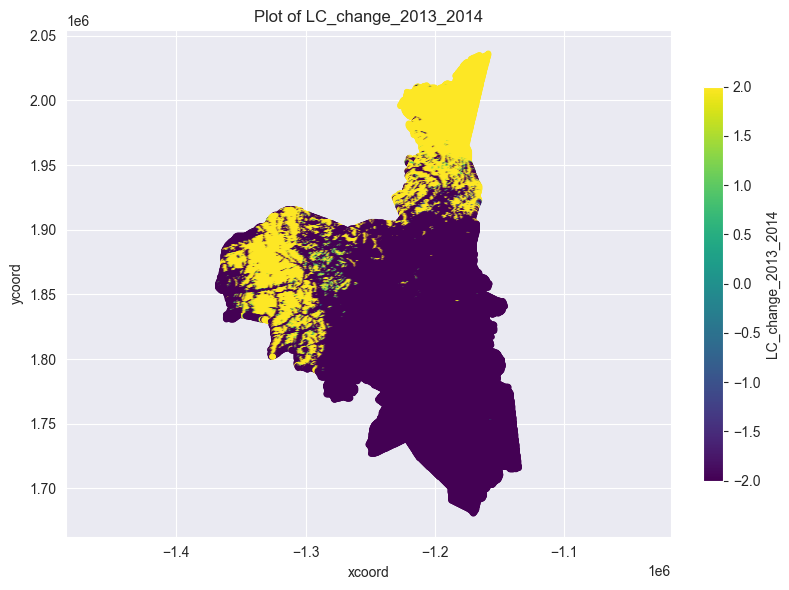

In [110]:
plot_column_locations(df, data_col="LC_change_2013_2014")

In [111]:
import pandas as pd
import numpy as np

# For statistical tests
from scipy.stats import linregress
# You can also use pymannkendall for Mann-Kendall
import pymannkendall as mk

# For spatial autocorrelation / hotspot analysis
import libpysal
import esda

# For clustering
from sklearn.cluster import KMeans, DBSCAN

# For machine learning
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier

# For causal inference
import pingouin as pg
from semopy import Model




2B. Mann-Kendall Trend Test
Mann-Kendall is a non-parametric test often used to detect monotonic trends in time series. We’ll use pymannkendall.

In [112]:
# 1. Identify NDVI columns
ndvi_cols = [col for col in df.columns if col.startswith("LC_change_")]

mk_results = []
for i, row in df.iterrows():
    ndvi_values = row[ndvi_cols].values
    if np.any(pd.isna(ndvi_values.astype(float))):
        mk_results.append((np.nan, np.nan))
        continue
    
    # Mann-Kendall
    result = mk.original_test(ndvi_values)
    mk_results.append((result.trend, result.p))
    
df["trend_LC_change"]  = [r[0] for r in mk_results]  # e.g. 'increasing', 'decreasing', 'no trend'
df["pvalue_LC_change"] = [r[1] for r in mk_results]


In [113]:
df["trend_LC_change"]

475       no trend
1039      no trend
1040      no trend
1603      no trend
1604      no trend
            ...   
433242    no trend
433804    no trend
433805    no trend
433806    no trend
434370    no trend
Name: trend_LC_change, Length: 168212, dtype: object

C:\Users\tilma\AppData\Local\Temp\ipykernel_10808\3362063387.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  default_colors = plt.cm.get_cmap("tab20", len(unique_vals))


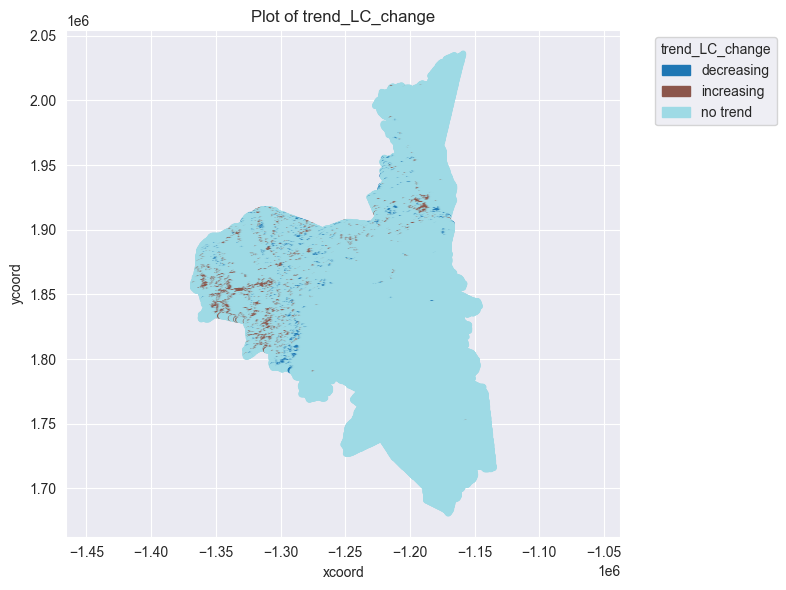

In [114]:
plot_column_locations(df, data_col="trend_LC_change", is_categorical=True)

3A. Constructing Coordinates & Weights
Assume you have df["row"] and df["col"] or df["xcoord"], df["ycoord"] for each pixel. If you do not, you need to reconstruct them from the raster transform. For example:

   pixel_id  year      NDVI  barren_change
0       475  2010  0.000010              2
1      1039  2010  0.000011              2
2      1040  2010  0.000010              2
3      1603  2010  0.000011              2
4      1604  2010  0.000010              2
5      1605  2010  0.000010              2
6      2154  2010  0.000012              2
7      2155  2010  0.000012              2
8      2156  2010  0.000012              2
9      2166  2010  0.000011              2


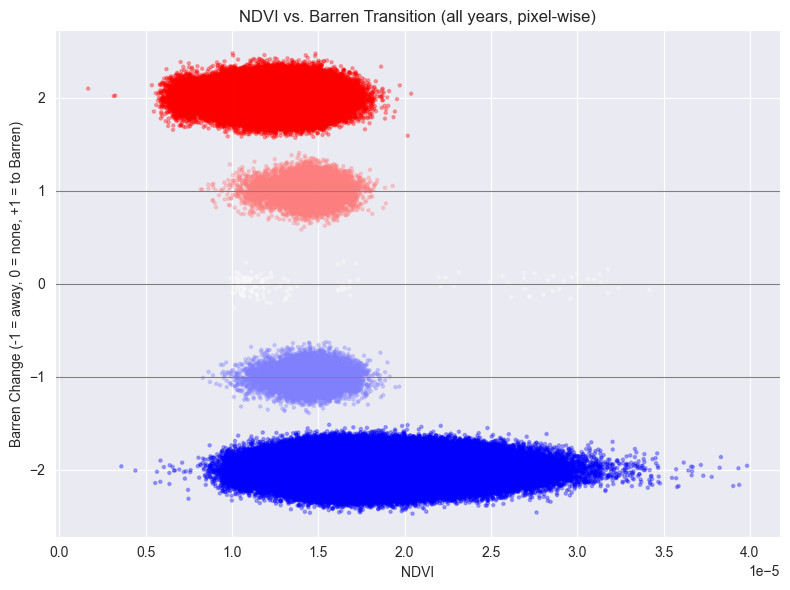

In [115]:
import numpy as np
import pandas as pd

for y in years:
    df[f"NDVI_{y}"]= 0.0001 *  df[f"NDVI_{y}"]

df_plot_rows = []

BARREN_CODE = 16  # <-- replace with your actual Barren code
all_years = range(2010, 2024)

# Identify which NDVI columns exist
ndvi_cols = [c for c in df.columns if c.startswith("NDVI_")]
# Identify which land cover columns exist
lc_cols = [c for c in df.columns if c.startswith("LC_")]

for y in all_years:
    # For each year y, we want NDVI_y, plus the barren transition from y -> y+1 (except for the last year)
    ndvi_col = f"NDVI_{y}"
    lc_col_1 = f"LC_change_{y}_{y+1}"


    # If we lack either NDVI_y or LC_y, skip
    if ndvi_col not in df.columns or lc_col_1 not in df.columns:
        continue

    # Grab NDVI (year t)
    ndvi_values = df[ndvi_col].values
    barren_change = df[lc_col_1].values

    # Build sub-DataFrame for this (year, pixel) combination
    sub_df = pd.DataFrame({
        "pixel_id": df["pixel_id"],
        "year": y,
        "NDVI": ndvi_values,
        "barren_change": barren_change
    })
    df_plot_rows.append(sub_df)

# Concatenate all pixel-year rows
df_plot = pd.concat(df_plot_rows, ignore_index=True)
print(df_plot.head(10))
# Columns: [pixel_id, year, NDVI, barren_change]

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
# We'll filter out rows where NDVI is NaN
df_plot_nonan = df_plot.dropna(subset=["NDVI"])

# Optionally add a small random jitter in y for better visibility, 
# so that points with y=0, +1, or -1 don’t overlap exactly.
jitter = 0.1 * np.random.randn(len(df_plot_nonan))  
y_values = df_plot_nonan["barren_change"] + jitter

plt.scatter(
    df_plot_nonan["NDVI"], 
    y_values, 
    c=df_plot_nonan["barren_change"],  # color by the same category or another variable
    cmap="bwr",  # or "RdYlGn", etc.
    alpha=0.3,   # partial transparency
    s=5          # small dots
)

plt.axhline(0, color="gray", linewidth=0.8)  # reference line for no change
plt.axhline(1, color="gray", linewidth=0.8)
plt.axhline(-1, color="gray", linewidth=0.8)

plt.xlabel("NDVI")
plt.ylabel("Barren Change (-1 = away, 0 = none, +1 = to Barren)")
plt.title("NDVI vs. Barren Transition (all years, pixel-wise)")

plt.tight_layout()
plt.show()



In [116]:
# 1. Identify NDVI columns
ndvi_cols = [col for col in df.columns if col.startswith("LC_change_")]

# Extract the years from the column names (e.g. NDVI_2010 -> 2010)
years_ndvi = [int(col.split("_")[2]) for col in ndvi_cols]
years_array = np.array(years_ndvi)

# 2. For each row (pixel), gather NDVI values over time and run linear regression
slopes = []
p_values = []
for i, row in df.iterrows():
    ndvi_values = row[ndvi_cols].values
    # If your data has NaNs, you can skip or handle them
    # For simplicity, skip this pixel if any NDVI is NaN
    if np.any(pd.isna(ndvi_values.astype(float))):
        slopes.append(np.nan)
        p_values.append(np.nan)
        continue
    
    # Do a simple linear regression: NDVI ~ year
    # years_array is the x, ndvi_values is the y
    slope, intercept, r_value, p_value, std_err = linregress(years_array, ndvi_values)
    slopes.append(slope)
    p_values.append(p_value)

df["trend_slope_LC_change"] = slopes
df["trend_pvalue_LC_change"] = p_values

# A negative slope => NDVI decreasing. A positive slope => increasing.
# p-value < 0.05 => statistically significant trend


AttributeError: 'float' object has no attribute 'shape'

Clusters    

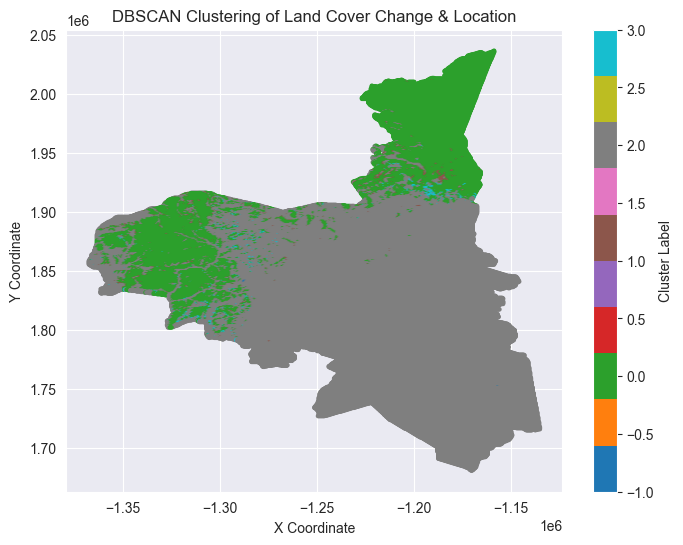

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Ensure data is numeric
df["LC_change_2022_2023"] = pd.to_numeric(df["LC_change_2022_2023"], errors="coerce")
df["xcoord"] = pd.to_numeric(df["xcoord"], errors="coerce")
df["ycoord"] = pd.to_numeric(df["ycoord"], errors="coerce")

# Drop any remaining NaN values
df.dropna(subset=["LC_change_2022_2023", "xcoord", "ycoord"], inplace=True)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(df[["LC_change_2022_2023", "xcoord", "ycoord"]])

db = DBSCAN(eps=0.5, min_samples=10).fit(features_scaled)
df["cluster_dbscan"] = db.labels_  # -1 means outlier/noise

plt.figure(figsize=(8, 6))
plt.scatter(df["xcoord"], df["ycoord"], c=df["cluster_dbscan"], cmap="tab10", s=5)
plt.colorbar(label="Cluster Label")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("DBSCAN Clustering of Land Cover Change & Location")
plt.show()



In [62]:
# 1. Define target and features
target_col = "LC_change_2022_2023"
feature_cols = [
    "NDVI_2022", "LST_2022", "POP_2022", "GPP_2022", "PRECIP_2022", "LC_2022"
    # plus any older-year stats you'd like
]
df_sub = df.dropna(subset=[target_col] + feature_cols)
X = df_sub[feature_cols].values
y = df_sub[target_col].values.astype(int)  # if land cover is categorical

# 2. Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X, y)

# 3. Feature importance
importance = clf.feature_importances_
for feat, imp in zip(feature_cols, importance):
    print(f"{feat} => {imp:.4f}")

# 4. Predict
df_sub["pre_LC_change_2022_2023"] = clf.predict(X)
accuracy = (df_sub["pre_LC_change_2022_2023"] == y).mean()
print("Classification accuracy:", accuracy)


NDVI_2022 => 0.0035
LST_2022 => 0.2162
POP_2022 => 0.0164
GPP_2022 => 0.1506
PRECIP_2022 => 0.0525
LC_2022 => 0.5608
Classification accuracy: 0.9893467766865622


In [63]:
# 1. Define target and features
target_col = "LC_change_2022_2023"
feature_cols = [
    "NDVI_2022", "LST_2022", "POP_2022", "GPP_2022", "PRECIP_2022"
    # plus any older-year stats you'd like
]
df_sub = df.dropna(subset=[target_col] + feature_cols)
X = df_sub[feature_cols].values
y = df_sub[target_col].values.astype(int)  # if land cover is categorical

# 2. Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X, y)

# 3. Feature importance
importance = clf.feature_importances_
for feat, imp in zip(feature_cols, importance):
    print(f"{feat} => {imp:.4f}")

# 4. Predict
df_sub["pre_LC_change_2022_2023"] = clf.predict(X)
accuracy = (df_sub["pre_LC_change_2022_2023"] == y).mean()
print("Classification accuracy:", accuracy)

NDVI_2022 => 0.0281
LST_2022 => 0.4420
POP_2022 => 0.0641
GPP_2022 => 0.3279
PRECIP_2022 => 0.1378
Classification accuracy: 0.9468052219817849


In [104]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# List of all available years
years = range(2010, 2023)  # Stops at 2022, since we need a `YEAR_YEAR+1` pair

# Empty list to collect training samples
dataset_list = []

# Loop through each year to create feature-target pairs
for y in years:
    target_col = f"LC_change_{y}_{y+1}"
    feature_cols = [
        f"NDVI_{y}", f"LST_{y}", f"POP_{y}", f"GPP_{y}"
    ]
    
    # Ensure only rows without NaN values are included
    df_subset = df.dropna(subset=[target_col] + feature_cols)
    
    # Append to list
    if not df_subset.empty:
        dataset_list.append(df_subset[feature_cols + [target_col]])

# Combine all year-pair datasets into one DataFrame
df_combined = pd.concat(dataset_list, ignore_index=True)

# Extract features (X) and target (y)
X = df_combined[feature_cols].values
y = df_combined[target_col].values.astype(int)  # Ensure categorical target

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Feature Importance
importance = clf.feature_importances_
print("Feature Importance:")
for feat, imp in zip(feature_cols, importance):
    print(f"{feat} => {imp:.4f}")

# Predictions on Test Set
y_pred = clf.predict(X_test)

# Compute Accuracy on Test Set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


KeyError: ['LC_change_2010_2011']

In [68]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# List of all available years
years = range(2010, 2023)  # Stops at 2022, since we need a `YEAR_YEAR+1` pair

# Empty list to collect training samples
dataset_list = []

# Loop through each year to create feature-target pairs
for y in years:
    target_col = f"LC_change_{y}_{y+1}"  # Target variable for classification
    feature_cols_reg = [
        f"NDVI_{y}", f"LST_{y}", f"POP_{y}", f"GPP_{y}", f"PRECIP_{y}"
    ]
    
    # Ensure only rows without NaN values are included
    df_subset = df.dropna(subset=[target_col] + feature_cols_reg)
    
    # Append to list
    if not df_subset.empty:
        dataset_list.append(df_subset[feature_cols_reg + [target_col]])

# Combine all year-pair datasets into one DataFrame
df_combined = pd.concat(dataset_list, ignore_index=True)

# Extract features (X) and target (y)
# Drop rows where target (`y_reg`) is still NaN after cleaning

# Convert to numeric and handle NaN or Inf values
y_reg = pd.to_numeric(df_combined[target_col], errors="coerce")  # Convert non-numeric to NaN
y_reg = np.nan_to_num(y_reg, nan=0.0, posinf=0.0, neginf=0.0)  # Replace NaN & Inf with 0
valid_rows = ~np.isnan(y_reg) & (np.abs(y_reg) < 1e6)  # Remove NaNs and extremely large values
X_reg = df_combined.loc[valid_rows, feature_cols_reg].values
y_reg = y_reg[valid_rows]  # Keep only valid y values
print(len(y_reg))


# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train an XGBoost Regressor
model_xgb = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
model_xgb.fit(X_train, y_train)

# Predictions on Test Set
y_pred = model_xgb.predict(X_test)

# Compute Mean Squared Error (MSE) on Test Set
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

# Feature Importance
print("Feature Importance:")
for feat, imp in zip(feature_cols_reg, model_xgb.feature_importances_):
    print(f"{feat} => {imp:.4f}")


2186756
Test MSE: 0.0317
Feature Importance:
NDVI_2022 => 0.0825
LST_2022 => 0.0283
POP_2022 => 0.0051
GPP_2022 => 0.8726
PRECIP_2022 => 0.0115


In [162]:
import pandas as pd
import itertools
from statsmodels.tsa.stattools import grangercausalitytests

# 1. Identify all relevant time-series columns
years = range(2010, 2024)  # From 2010 to 2023

# Define the different time-series variables to analyze
time_series_vars = ["NDVI", "LST", "GPP", "POP", "LC"]

# Automatically find column names for each variable over the years
ts_columns = {var: [f"{var}_{y}" for y in years] for var in time_series_vars}

# 2. Drop rows where ANY time-series variable is NaN
df_ts = df.dropna(subset=[col for cols in ts_columns.values() for col in cols])

# Select only numeric columns

numeric_df = df_ts.select_dtypes(include=[np.number])

# Check for infinity values in numeric columns
inf_mask = numeric_df.applymap(np.isinf)

# Display columns containing infinity values
print("Columns containing infinity values:")
print(inf_mask.any())

# Display rows where at least one numeric value is infinity
df_inf_rows = numeric_df[inf_mask.any(axis=1)]
print("\nRows containing infinity values:")
print(df_inf_rows)


# 3. Prepare Granger Causality analysis for all variable pairs
max_lag = 2  # Testing up to a 2-year lag
pairs = list(itertools.combinations(time_series_vars, 2))  # Create all variable pairs

print(pairs)
gc_results = {}

# 4. Loop through all time-series pairs and apply Granger Causality Test
for x_var, y_var in pairs:
    try:
        # Extract full time series (flattening all pixels over time)
        x_series = df_ts[[f"{x_var}_{y}" for y in years]].mean(axis=0)  # Use mean for region-wide trends
        y_series = df_ts[[f"{y_var}_{y}" for y in years]].mean(axis=0)

        # Create DataFrame for Granger causality
        data_gc = pd.DataFrame({x_var: x_series, y_var: y_series})

        # Run Granger causality test
        gc_test = grangercausalitytests(data_gc, max_lag, verbose=False)

        # Store p-values for each lag
        p_values = {lag: gc_test[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)}
        gc_results[f"{x_var} → {y_var}"] = p_values

    except Exception as e:
        print(f"Error in Granger test for {x_var} → {y_var}: {e}")

# 5. Print Results
print("\n**Granger Causality Test Results:**")
for key, p_vals in gc_results.items():
    print(f"\n{key}")
    for lag, p in p_vals.items():
        significance = "***" if p < 0.01 else "**" if p < 0.05 else "*" if p < 0.1 else ""
        print(f"Lag {lag}: p-value = {p:.4f} {significance}")


C:\Users\tilma\AppData\Local\Temp\ipykernel_10808\3554257064.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  inf_mask = numeric_df.applymap(np.isinf)


Columns containing infinity values:
LC_2010             False
NDVI_2010           False
LST_2010            False
POP_2010            False
GPP_2010            False
                    ...  
pvalue_LC_change    False
is_desert           False
is_vegetation       False
desert_risk_2023    False
desert_risk_2024    False
Length: 107, dtype: bool

Rows containing infinity values:
Empty DataFrame
Columns: [LC_2010, NDVI_2010, LST_2010, POP_2010, GPP_2010, PRECIP_2010, pixel_id, LC_2011, NDVI_2011, LST_2011, POP_2011, GPP_2011, PRECIP_2011, LC_2012, NDVI_2012, LST_2012, POP_2012, GPP_2012, PRECIP_2012, LC_2013, NDVI_2013, LST_2013, POP_2013, GPP_2013, PRECIP_2013, LC_2014, NDVI_2014, LST_2014, POP_2014, GPP_2014, PRECIP_2014, LC_2015, NDVI_2015, LST_2015, POP_2015, GPP_2015, PRECIP_2015, LC_2016, NDVI_2016, LST_2016, POP_2016, GPP_2016, PRECIP_2016, LC_2017, NDVI_2017, LST_2017, POP_2017, GPP_2017, PRECIP_2017, LC_2018, NDVI_2018, LST_2018, POP_2018, GPP_2018, PRECIP_2018, LC_2019, NDVI_20

In [78]:
print("Any NaN remaining?", df.isna().values.any())


Any NaN remaining? False


In [119]:
import numpy as np
import pandas as pd
import faiss
from sklearn.preprocessing import StandardScaler

# Assume filtered_df is already loaded
# Drop non-numeric columns (if any)
numeric_df = df_filtered.select_dtypes(include=[np.number])

# Normalize the data for better similarity search
scaler = StandardScaler()
normalized_data = scaler.fit_transform(numeric_df)

# Convert to NumPy float32 array (required for FAISS)
embeddings = np.array(normalized_data).astype("float32")

# Store embeddings back into DataFrame
df_filtered["embeddings"] = list(embeddings)

# Save to CSV or JSON (optional)
df_filtered.to_csv("filtered_numeric_data_with_embeddings.csv", index=False)

print("Embeddings generated successfully for structured numerical data!")


Embeddings generated successfully for structured numerical data!


In [121]:
import faiss
import numpy as np

# Initialize FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)  # L2 distance for similarity search

# Add data to FAISS index
index.add(embeddings)

# Save FAISS index to a file
faiss.write_index(index, "numeric_vector_database.index")

print("Vector database created and stored with FAISS!")


Vector database created and stored with FAISS!


In [131]:
# Create binary target variable: 1 = Desert (LC = 16), 0 = Not Desert
df["is_desert"] = (df["LC_2022"] == 16).astype(int)  # Label desert points in 2022
df["is_vegetation"] = ((df["LC_2022"] == 7) | (df["LC_2022"] == 7)).astype(int) 

In [137]:
from sklearn.model_selection import train_test_split

# Define features: Use environmental & human impact factors from past years
feature_cols = []
years = list(range(2010, 2022))  # Use past years to predict 2022

for y in years:
    feature_cols.extend([f"NDVI_{y}", f"LST_{y}", f"POP_{y}", f"GPP_{y}"])  # Select features

# Drop rows with missing values
df_clean = df.dropna(subset=feature_cols + ["is_desert"])
X = df_clean[feature_cols].values  # Feature matrix
y = df_clean["is_desert"].values   # Target variable (0 or 1)
y2 = df_clean["is_vegetation"].values


# Split data for training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [148]:
y.sum()

44615

In [138]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train model
clf = XGBClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Accuracy: 0.9957
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33496
           1       0.53      0.12      0.20       147

    accuracy                           1.00     33643
   macro avg       0.76      0.56      0.60     33643
weighted avg       0.99      1.00      0.99     33643



In [139]:
# Predict risk for 2023 and 2024
df["desert_risk_2023"] = clf.predict(df[feature_cols])
df["desert_risk_2024"] = clf.predict(df[feature_cols])  # You can use more advanced time-shifting

print("Predictions for 2023 and 2024 added to dataset!")
print(clf.predict(df[feature_cols]))

Predictions for 2023 and 2024 added to dataset!
[0 0 0 ... 0 0 0]


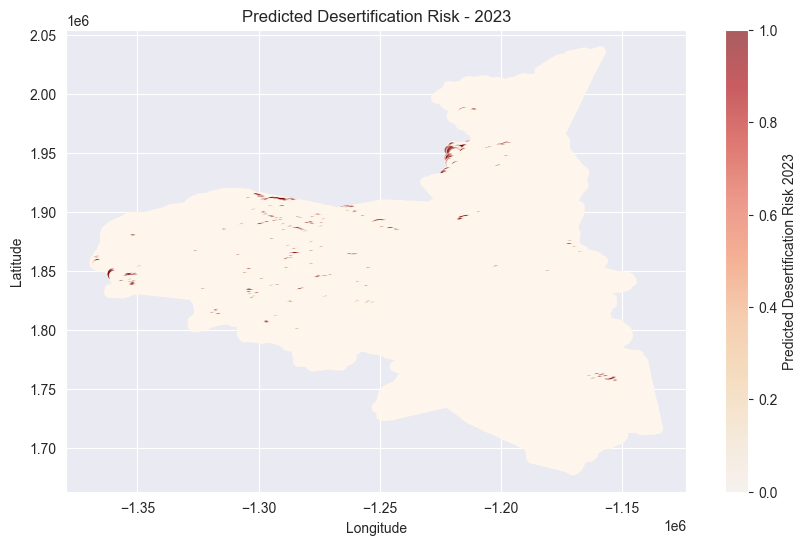

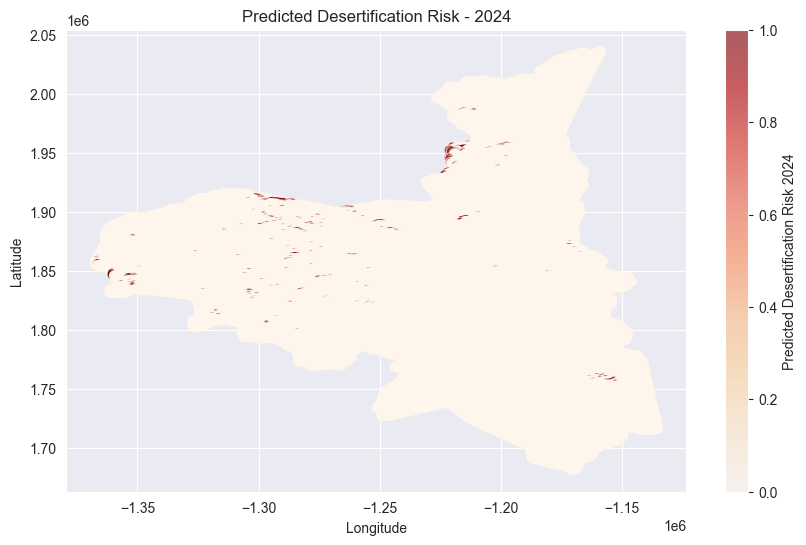

In [140]:
import matplotlib.pyplot as plt

def plot_desert_risk(df, year):
    plt.figure(figsize=(10, 6))
    plt.scatter(df["xcoord"], df["ycoord"], c=df[f"desert_risk_{year}"], cmap="OrRd", alpha=0.6)
    plt.colorbar(label=f"Predicted Desertification Risk {year}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Predicted Desertification Risk - {year}")
    plt.show()

# Plot 2023 and 2024 predictions
plot_desert_risk(df, 2023)
plot_desert_risk(df, 2024)


In [158]:
import pandas as pd

# Prepare an empty list for transformed data
rows = []

years = list(range(2010, 2023))  # Use past years as features, predict for next year

for y in years:
    next_year = y + 1  # Predict desertification in next year
    
    if f"LC_{next_year}" not in df.columns:
        continue  # Skip if next year's data isn't available

    temp_df = df[[
        f"NDVI_{y}", f"LST_{y}", f"POP_{y}",  f"GPP_{y}", "xcoord", "ycoord",  f"LC_{y}"
    ]].copy()

    # Rename columns to be consistent across years
    temp_df.columns = ["NDVI", "LST", "POP", "GPP", "xcoord", "ycoord", "LC"]

    # Create the target variable: 1 if land cover changed to 'Desert' (16), else 0
    temp_df["is_desert"] = (df[f"LC_{next_year}"] == 16).astype(int)

    # Store which year this transition represents
    temp_df["year"] = y

    rows.append(temp_df)

# Convert to DataFrame
df_transformed = pd.concat(rows, ignore_index=True)

# Check new data format
print(df_transformed.head())


       NDVI        LST       POP  GPP        xcoord        ycoord    LC  \
0  0.000010  40.922581  0.006259  0.0 -1.158745e+06  2.036259e+06  16.0   
1  0.000011  41.056068  0.005568  0.0 -1.159208e+06  2.035796e+06  16.0   
2  0.000010  40.807373  0.005553  0.0 -1.158745e+06  2.035796e+06  16.0   
3  0.000011  40.763355  0.005525  0.0 -1.159672e+06  2.035333e+06  16.0   
4  0.000010  40.485077  0.005415  0.0 -1.159208e+06  2.035333e+06  16.0   

   is_desert  year  
0          1  2010  
1          1  2010  
2          1  2010  
3          1  2010  
4          1  2010  


In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Select features
feature_cols = ["NDVI", "LST", "POP", "GPP", "LC"]

# Drop missing values
df_clean = df_transformed.dropna(subset=feature_cols + ["is_desert"])

X = df_clean[feature_cols].values  # Features
y = df_clean["is_desert"].values   # Target

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Accuracy: 0.9835
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    321878
           1       0.97      0.97      0.97    115474

    accuracy                           0.98    437352
   macro avg       0.98      0.98      0.98    437352
weighted avg       0.98      0.98      0.98    437352



In [160]:
import pandas as pd

# Prepare an empty list for transformed data
rows = []

years = list(range(2010, 2022))  # Use past years as features, predict for next year

for y in years:
    next_year = y + 2  # Predict desertification in next year
    
    if f"LC_{next_year}" not in df.columns:
        continue  # Skip if next year's data isn't available

    temp_df = df[[
        f"NDVI_{y}", f"LST_{y}", f"POP_{y}",  f"GPP_{y}", "xcoord", "ycoord", f"LC_{y}"
    ]].copy()

    # Rename columns to be consistent across years
    temp_df.columns = ["NDVI", "LST", "POP", "GPP", "xcoord", "ycoord", "LC"]

    # Create the target variable: 1 if land cover changed to 'Desert' (16), else 0
    temp_df["is_desert"] = (df[f"LC_{next_year}"] == 16).astype(int)

    # Store which year this transition represents
    temp_df["year"] = y

    rows.append(temp_df)

# Convert to DataFrame
df_transformed = pd.concat(rows, ignore_index=True)

# Check new data format
print(df_transformed.head())


       NDVI        LST       POP  GPP        xcoord        ycoord    LC  \
0  0.000010  40.922581  0.006259  0.0 -1.158745e+06  2.036259e+06  16.0   
1  0.000011  41.056068  0.005568  0.0 -1.159208e+06  2.035796e+06  16.0   
2  0.000010  40.807373  0.005553  0.0 -1.158745e+06  2.035796e+06  16.0   
3  0.000011  40.763355  0.005525  0.0 -1.159672e+06  2.035333e+06  16.0   
4  0.000010  40.485077  0.005415  0.0 -1.159208e+06  2.035333e+06  16.0   

   is_desert  year  
0          1  2010  
1          1  2010  
2          1  2010  
3          1  2010  
4          1  2010  


In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Select features
feature_cols = ["NDVI", "LST", "POP", "GPP", "LC"]

# Drop missing values
df_clean = df_transformed.dropna(subset=feature_cols + ["is_desert"])

X = df_clean[feature_cols].values  # Features
y = df_clean["is_desert"].values   # Target

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Accuracy: 0.9718
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    297432
           1       0.93      0.96      0.95    106277

    accuracy                           0.97    403709
   macro avg       0.96      0.97      0.96    403709
weighted avg       0.97      0.97      0.97    403709



In [163]:
import pandas as pd

# Prepare an empty list for transformed data
rows = []

years = list(range(2010, 2021))  # Use past years as features, predict for next year

for y in years:
    next_year = y + 3  # Predict desertification in next year
    
    if f"LC_{next_year}" not in df.columns:
        continue  # Skip if next year's data isn't available

    temp_df = df[[
        f"NDVI_{y}", f"LST_{y}", f"POP_{y}",  f"GPP_{y}", "xcoord", "ycoord", f"LC_{y}"
    ]].copy()

    # Rename columns to be consistent across years
    temp_df.columns = ["NDVI", "LST", "POP", "GPP", "xcoord", "ycoord", "LC"]

    # Create the target variable: 1 if land cover changed to 'Desert' (16), else 0
    temp_df["is_desert"] = (df[f"LC_{next_year}"] == 16).astype(int)

    # Store which year this transition represents
    temp_df["year"] = y

    rows.append(temp_df)

# Convert to DataFrame
df_transformed = pd.concat(rows, ignore_index=True)

# Check new data format
print(df_transformed.head())

       NDVI        LST       POP  GPP        xcoord        ycoord    LC  \
0  0.000010  40.922581  0.006259  0.0 -1.158745e+06  2.036259e+06  16.0   
1  0.000011  41.056068  0.005568  0.0 -1.159208e+06  2.035796e+06  16.0   
2  0.000010  40.807373  0.005553  0.0 -1.158745e+06  2.035796e+06  16.0   
3  0.000011  40.763355  0.005525  0.0 -1.159672e+06  2.035333e+06  16.0   
4  0.000010  40.485077  0.005415  0.0 -1.159208e+06  2.035333e+06  16.0   

   is_desert  year  
0          1  2010  
1          1  2010  
2          1  2010  
3          1  2010  
4          1  2010  


In [164]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Select features
feature_cols = ["NDVI", "LST", "POP", "GPP", "LC"]

# Drop missing values
df_clean = df_transformed.dropna(subset=feature_cols + ["is_desert"])

X = df_clean[feature_cols].values  # Features
y = df_clean["is_desert"].values   # Target

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Accuracy: 0.9640
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    272840
           1       0.91      0.95      0.93     97227

    accuracy                           0.96    370067
   macro avg       0.95      0.96      0.95    370067
weighted avg       0.96      0.96      0.96    370067



In [168]:
import pandas as pd

# Prepare an empty list for transformed data
rows = []
years = list(range(2010, 2023))  # Use past years as features, predict for next year

for y in years:
    next_year = y + 1  # Predict desertification in next year
    
    if f"LC_{next_year}" not in df.columns:
        continue  # Skip if next year's data isn't available

    temp_df = df[[
        f"NDVI_{y}", f"LST_{y}", f"POP_{y}", f"GPP_{y}", "xcoord", "ycoord", f"LC_{y}"
    ]].copy()

    # Compute change features (difference from previous year)
    if y > 2010:  # Can't compute for the first year
        temp_df["ΔNDVI"] = df[f"NDVI_{y}"] - df[f"NDVI_{y-1}"]
        temp_df["ΔLST"] = df[f"LST_{y}"] - df[f"LST_{y-1}"]
        temp_df["ΔPOP"] = df[f"POP_{y}"] - df[f"POP_{y-1}"]
        temp_df["ΔGPP"] = df[f"GPP_{y}"] - df[f"GPP_{y-1}"]
    else:
        temp_df["ΔNDVI"] = 0
        temp_df["ΔLST"] = 0
        temp_df["ΔPOP"] = 0
        temp_df["ΔGPP"] = 0


    # Rename columns for consistency
    temp_df.columns = ["NDVI", "LST", "POP", "GPP", "LC", "xcoord", "ycoord",
                       "ΔNDVI", "ΔLST", "ΔPOP", "ΔGPP"]

    # Create the target variable: 1 if land cover changed to 'Desert' (16), else 0
    temp_df["is_desert"] = (df[f"LC_{next_year}"] == 16).astype(int)

    # Store which year this transition represents
    temp_df["year"] = y

    rows.append(temp_df)

# Convert to DataFrame
df_transformed = pd.concat(rows, ignore_index=True)

# Check new data format
print(df_transformed.head())


       NDVI        LST       POP  GPP            LC        xcoord  ycoord  \
0  0.000010  40.922581  0.006259  0.0 -1.158745e+06  2.036259e+06    16.0   
1  0.000011  41.056068  0.005568  0.0 -1.159208e+06  2.035796e+06    16.0   
2  0.000010  40.807373  0.005553  0.0 -1.158745e+06  2.035796e+06    16.0   
3  0.000011  40.763355  0.005525  0.0 -1.159672e+06  2.035333e+06    16.0   
4  0.000010  40.485077  0.005415  0.0 -1.159208e+06  2.035333e+06    16.0   

   ΔNDVI  ΔLST  ΔPOP  ΔGPP  is_desert  year  
0    0.0   0.0   0.0   0.0          1  2010  
1    0.0   0.0   0.0   0.0          1  2010  
2    0.0   0.0   0.0   0.0          1  2010  
3    0.0   0.0   0.0   0.0          1  2010  
4    0.0   0.0   0.0   0.0          1  2010  


In [169]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Select features
feature_cols = ["NDVI", "LST", "POP", "GPP", "LC",
                "ΔNDVI", "ΔLST", "ΔPOP", "ΔGPP"]

# Drop missing values
df_clean = df_transformed.dropna(subset=feature_cols + ["is_desert"])

X = df_clean[feature_cols].values  # Features
y = df_clean["is_desert"].values   # Target

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Accuracy: 0.9179
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94    321878
           1       0.77      0.98      0.86    115474

    accuracy                           0.92    437352
   macro avg       0.88      0.94      0.90    437352
weighted avg       0.93      0.92      0.92    437352



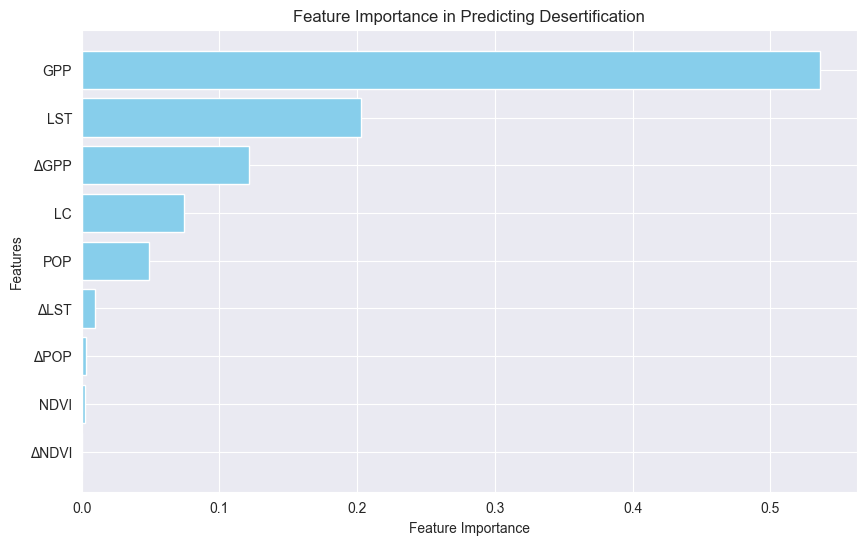

In [170]:
# Feature Importance
import matplotlib.pyplot as plt
import numpy as np

feature_importances = clf.feature_importances_

# Sort by importance
sorted_idx = np.argsort(feature_importances)
sorted_features = np.array(feature_cols)[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, feature_importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Predicting Desertification")
plt.show()


In [171]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Select features
feature_cols = ["NDVI", "LST", "POP", "GPP", "LC",
                "ΔNDVI", "ΔLST", "ΔPOP", "ΔGPP"]

# Drop missing values
df_clean = df_transformed.dropna(subset=feature_cols + ["is_desert"])

X = df_clean[feature_cols].values  # Features
y = df_clean["is_desert"].values   # Target

# Train on 2010-2020, Test on 2021-2022
df_train = df_clean[df_clean["year"] <= 2020]
df_test = df_clean[df_clean["year"] > 2020]  # Only 2021 and 2022

X_train = df_train[feature_cols].values
y_train = df_train["is_desert"].values

X_test = df_test[feature_cols].values
y_test = df_test["is_desert"].values

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Accuracy: 0.9238
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95    247269
           1       0.79      0.97      0.87     89155

    accuracy                           0.92    336424
   macro avg       0.89      0.94      0.91    336424
weighted avg       0.94      0.92      0.93    336424



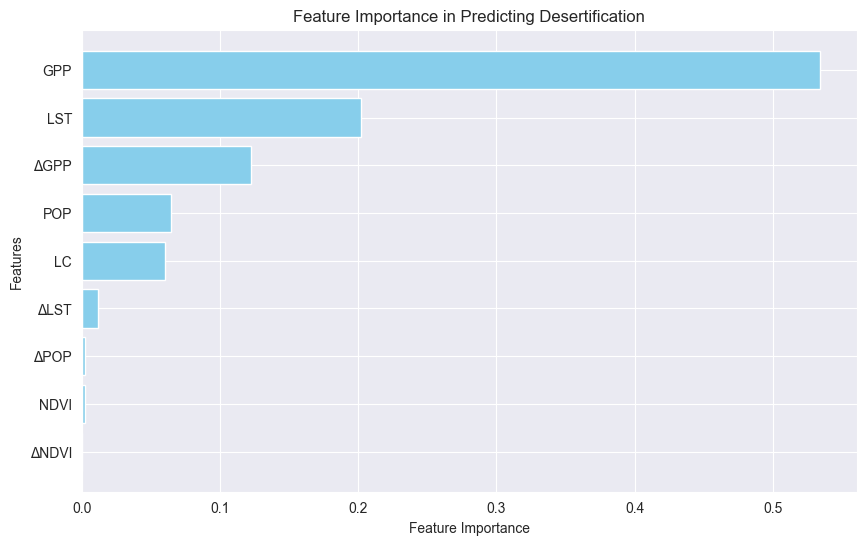

In [172]:

# Feature Importance
import matplotlib.pyplot as plt
import numpy as np

feature_importances = clf.feature_importances_

# Sort by importance
sorted_idx = np.argsort(feature_importances)
sorted_features = np.array(feature_cols)[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, feature_importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Predicting Desertification")
plt.show()

In [173]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train a logistic regression model
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict on test data
y_pred = log_reg.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.8987
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93    247269
           1       0.73      0.98      0.84     89155

    accuracy                           0.90    336424
   macro avg       0.86      0.92      0.88    336424
weighted avg       0.92      0.90      0.90    336424



In [174]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict risk scores (0-1 range)
y_pred = lin_reg.predict(X_test)

# Compute Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Linear Regression MSE: {mse:.4f}")

# Convert risk scores into binary (Threshold = 0.5)
y_pred_binary = (y_pred > 0.5).astype(int)
print("Classification Report (Converted to Binary):")
print(classification_report(y_test, y_pred_binary))


Linear Regression MSE: 0.0805
Classification Report (Converted to Binary):
              precision    recall  f1-score   support

           0       0.96      0.95      0.96    247269
           1       0.87      0.88      0.88     89155

    accuracy                           0.93    336424
   macro avg       0.92      0.92      0.92    336424
weighted avg       0.94      0.93      0.93    336424



In [175]:
import numpy as np

feature_importances = log_reg.coef_[0]  # Coefficients
sorted_idx = np.argsort(feature_importances)
sorted_features = np.array(feature_cols)[sorted_idx]

print("Feature Importances (Logistic Regression):")
for feat, imp in zip(sorted_features, feature_importances[sorted_idx]):
    print(f"{feat}: {imp:.4f}")


Feature Importances (Logistic Regression):
ΔLST: -0.1415
POP: -0.0141
GPP: -0.0075
ΔPOP: -0.0005
NDVI: -0.0000
ΔNDVI: 0.0000
LC: 0.0000
ΔGPP: 0.0041
LST: 0.3104


  Feature    Importance
0    NDVI -5.728120e+04
5   ΔNDVI  5.568607e+04
1     LST  8.233564e-02
2     POP -7.193006e-02
7    ΔPOP  4.073766e-02
6    ΔLST -4.066438e-02
3     GPP -7.585987e-05
8    ΔGPP  3.928967e-05
4      LC  2.950710e-07


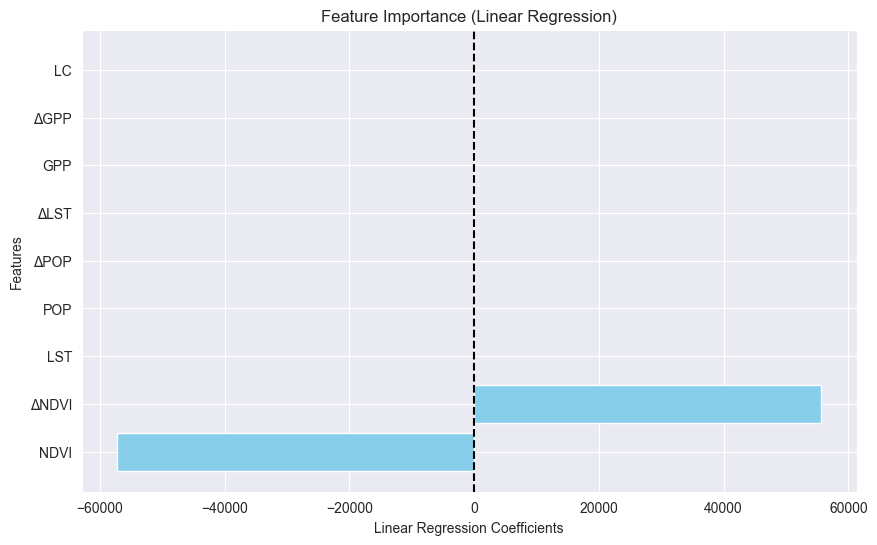

In [177]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# Extract feature importance from linear regression model
feature_importance = lin_reg.coef_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": feature_importance
})

# Sort by absolute importance (strongest predictors first)
feature_importance_df["Abs_Importance"] = np.abs(feature_importance_df["Importance"])
feature_importance_df = feature_importance_df.sort_values(by="Abs_Importance", ascending=False)

# Print the feature importance values
print(feature_importance_df[["Feature", "Importance"]])

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Linear Regression Coefficients")
plt.ylabel("Features")
plt.title("Feature Importance (Linear Regression)")
plt.axvline(x=0, color="black", linestyle="--")  # Add a vertical line at 0
plt.show()
